Import Libraries and Install Dependencies

In [22]:
!pip install seaborn
!pip install tabulate



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import joblib
import os

Custom Metric: Mean Absolute Percentage Error (MAPE)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

Loading the dataset

In [42]:
try:
    df = pd.read_csv('salary_prediction_data.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'salary_prediction_data.csv' not found. Please ensure the file is in the correct directory.")
    raise SystemExit("Dataset not found. Please upload it or check the path.")

Dataset loaded successfully!


In [43]:
#Basic information about dataset

print("\n--- Dataset Head ---")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\n--- Dataset Info ---")
df.info()

print("\n--- Missing Values ---")
print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))

print("\n--- Descriptive Statistics ---")
print(df.describe().to_markdown(numalign="left", stralign="left"))


--- Dataset Head ---
| Education   | Experience   | Location   | Job_Title   | Age   | Gender   | Salary   |
|:------------|:-------------|:-----------|:------------|:------|:---------|:---------|
| High School | 8            | Urban      | Manager     | 63    | Male     | 84620.1  |
| PhD         | 11           | Suburban   | Director    | 59    | Male     | 142591   |
| Bachelor    | 28           | Suburban   | Manager     | 61    | Female   | 97800.3  |
| High School | 29           | Rural      | Director    | 45    | Male     | 96834.7  |
| PhD         | 25           | Urban      | Analyst     | 26    | Female   | 132158   |

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Education   1000 non-null   object 
 1   Experience  1000 non-null   int64  
 2   Location    1000 non-null   object 
 3   Job_Title   1000 non-null

Exploratory Data Analysis (EDA) and Outlier Handling

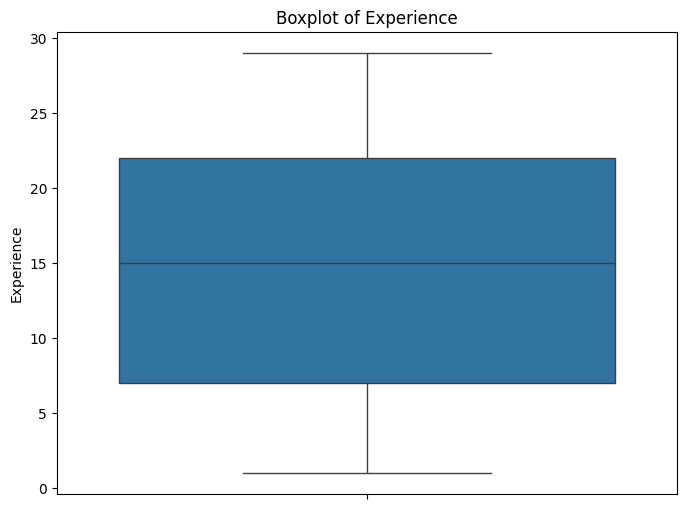

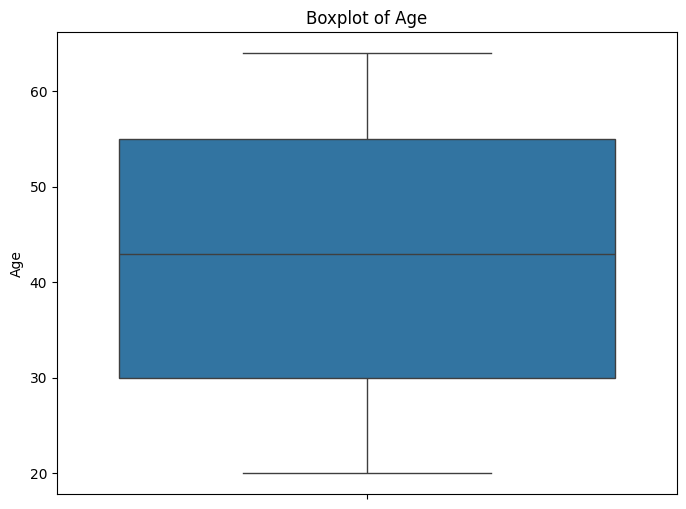

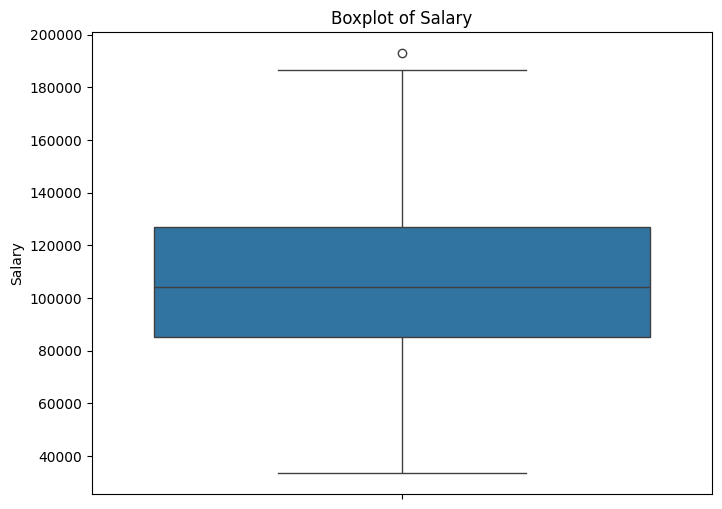

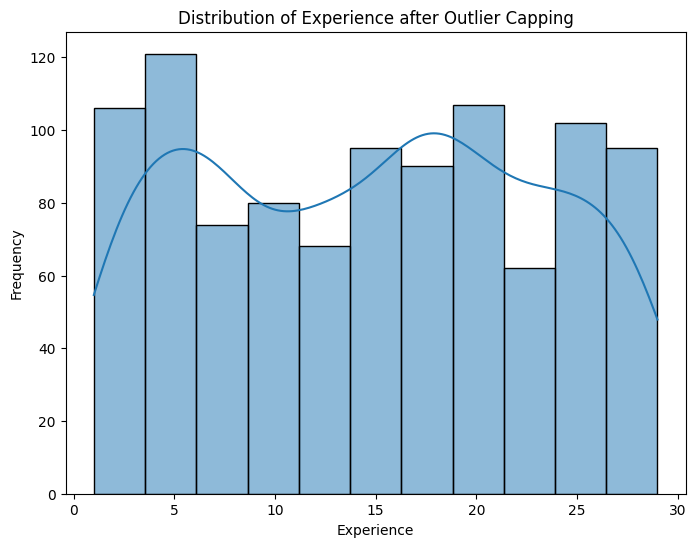

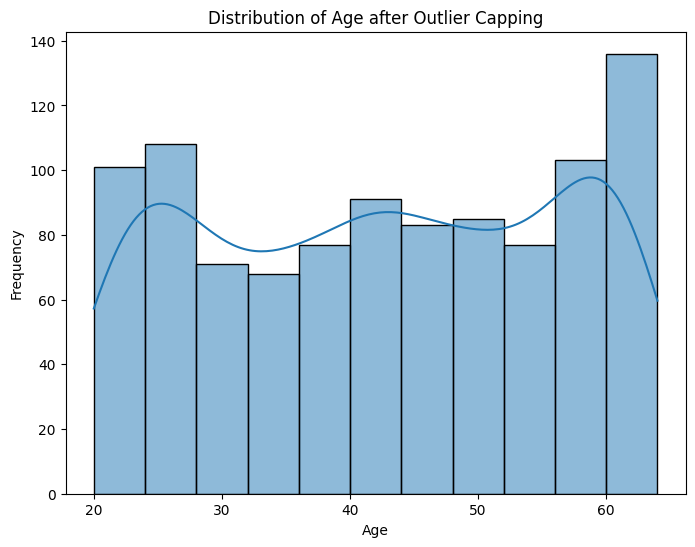

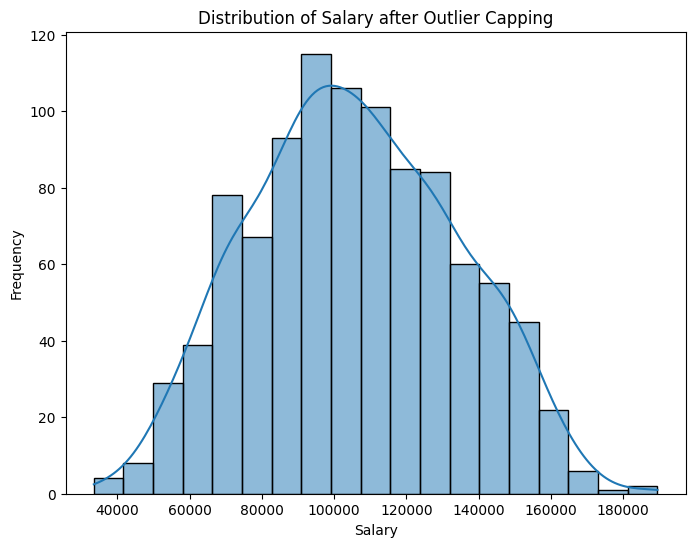

In [ ]:
numerical_cols = ['Experience', 'Age', 'Salary']
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.show()

for col in ['Experience', 'Age', 'Salary']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col} after Outlier Capping')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

Feature engineering / Preprocessing

In [45]:
categorical_cols = ['Education', 'Location', 'Job_Title', 'Gender']

# Store LabelEncoders for later use in Streamlit app
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le
    print(f"\n--- {col} Mappings ---")
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(mapping)

# Save the encoders
joblib.dump(encoders, 'label_encoders.pkl')
print("\nLabel encoders saved to 'label_encoders.pkl'")

# Define features (X) and target (y)
X = df.drop('Salary', axis=1)
y = df['Salary']


--- Education Mappings ---
{'Bachelor': np.int64(0), 'High School': np.int64(1), 'Master': np.int64(2), 'PhD': np.int64(3)}

--- Location Mappings ---
{'Rural': np.int64(0), 'Suburban': np.int64(1), 'Urban': np.int64(2)}

--- Job_Title Mappings ---
{'Analyst': np.int64(0), 'Director': np.int64(1), 'Engineer': np.int64(2), 'Manager': np.int64(3)}

--- Gender Mappings ---
{'Female': np.int64(0), 'Male': np.int64(1)}

Label encoders saved to 'label_encoders.pkl'


Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


joblib.dump(scaler, 'scaler.pkl')
print("StandardScaler saved to 'scaler.pkl'")

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


StandardScaler saved to 'scaler.pkl'


Model Training and Evaluation (Regression Models)

In [47]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "SVR": SVR()
}

evaluation_metrics = {}

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")
    model.fit(X_train_scaled_df, y_train)

    # Predictions on training and test sets
    y_train_pred = model.predict(X_train_scaled_df)
    y_test_pred = model.predict(X_test_scaled_df)

    # Calculate metrics for training set
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

    # Calculate metrics for test set
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    evaluation_metrics[name] = {
        'Train MAE': train_mae, 'Train RMSE': train_rmse, 'Train R2': train_r2, 'Train MAPE': train_mape,
        'Test MAE': test_mae, 'Test RMSE': test_rmse, 'Test R2': test_r2, 'Test MAPE': test_mape
    }

    print(f"  Train Metrics:")
    print(f"    MAE: {train_mae:.4f}")
    print(f"    RMSE: {train_rmse:.4f}")
    print(f"    R-squared: {train_r2:.4f}")
    print(f"    MAPE: {train_mape:.2f}%")
    print(f"  Test Metrics:")
    print(f"    MAE: {test_mae:.4f}")
    print(f"    RMSE: {test_rmse:.4f}")
    print(f"    R-squared: {test_r2:.4f}")
    print(f"    MAPE: {test_mape:.2f}%")


--- Training and Evaluating LinearRegression ---
  Train Metrics:
    MAE: 15033.7834
    RMSE: 18714.1876
    R-squared: 0.5577
    MAPE: 16.50%
  Test Metrics:
    MAE: 15458.1423
    RMSE: 18812.9058
    R-squared: 0.5665
    MAPE: 16.92%

--- Training and Evaluating RandomForestRegressor ---
  Train Metrics:
    MAE: 3442.9717
    RMSE: 4318.8934
    R-squared: 0.9764
    MAPE: 3.58%
  Test Metrics:
    MAE: 9290.7783
    RMSE: 11272.7304
    R-squared: 0.8444
    MAPE: 9.47%

--- Training and Evaluating GradientBoostingRegressor ---
  Train Metrics:
    MAE: 6721.9923
    RMSE: 8495.4852
    R-squared: 0.9089
    MAPE: 7.02%
  Test Metrics:
    MAE: 8458.9960
    RMSE: 10456.0978
    R-squared: 0.8661
    MAPE: 8.65%

--- Training and Evaluating KNeighborsRegressor ---
  Train Metrics:
    MAE: 9956.2756
    RMSE: 12481.2824
    R-squared: 0.8033
    MAPE: 10.63%
  Test Metrics:
    MAE: 12709.2887
    RMSE: 16103.4775
    R-squared: 0.6824
    MAPE: 13.47%

--- Training and Eval

Model Evaluation Summary and Best Model Selection

In [ ]:
print("\n--- Model Evaluation Summary (Test Set) ---")
metrics_df = pd.DataFrame.from_dict(evaluation_metrics, orient='index')

metrics_df_test = metrics_df[['Test R2', 'Test MAE', 'Test RMSE', 'Test MAPE']]
print(metrics_df_test.sort_values(by='Test R2', ascending=False).to_markdown(numalign="left", stralign="left"))

# Select and Save the Best Model
best_model_name = max(evaluation_metrics, key=lambda k: evaluation_metrics[k]['Test R2'])
best_model_metrics = evaluation_metrics[best_model_name]
best_model = models[best_model_name]

print(f"\n✅ Best model: {best_model_name} with Test R-squared {best_model_metrics['Test R2']:.4f}")

# Save Model Performance Metrics for Streamlit App 
joblib.dump(metrics_df_test, "model_performance_metrics.pkl")
print("✅ Model performance metrics saved to 'model_performance_metrics.pkl'")

# Select and Save the Best Model
best_model_name = max(evaluation_metrics, key=lambda k: evaluation_metrics[k]['Test R2'])
best_model_metrics = evaluation_metrics[best_model_name]
best_model = models[best_model_name]

print(f"\n✅ Best model: {best_model_name} with Test R-squared {best_model_metrics['Test R2']:.4f}")

# Save the best model
joblib.dump(best_model, "best_salary_model.pkl")
print("✅ Saved best model as 'best_salary_model.pkl'")



--- Model Evaluation Summary (Test Set) ---
|                           | Test R2     | Test MAE   | Test RMSE   | Test MAPE   |
|:--------------------------|:------------|:-----------|:------------|:------------|
| GradientBoostingRegressor | 0.866104    | 8459       | 10456.1     | 8.64739     |
| RandomForestRegressor     | 0.844372    | 9290.78    | 11272.7     | 9.46911     |
| KNeighborsRegressor       | 0.682408    | 12709.3    | 16103.5     | 13.4661     |
| LinearRegression          | 0.566548    | 15458.1    | 18812.9     | 16.9235     |
| SVR                       | -0.00641617 | 23102.2    | 28666.5     | 24.8407     |

✅ Best model: GradientBoostingRegressor with Test R-squared 0.8661
✅ Model performance metrics saved to 'model_performance_metrics.pkl'

✅ Best model: GradientBoostingRegressor with Test R-squared 0.8661
✅ Saved best model as 'best_salary_model.pkl'


Visualizing Model Performance (Best Model)


--- Visualizing Performance of Best Model ---


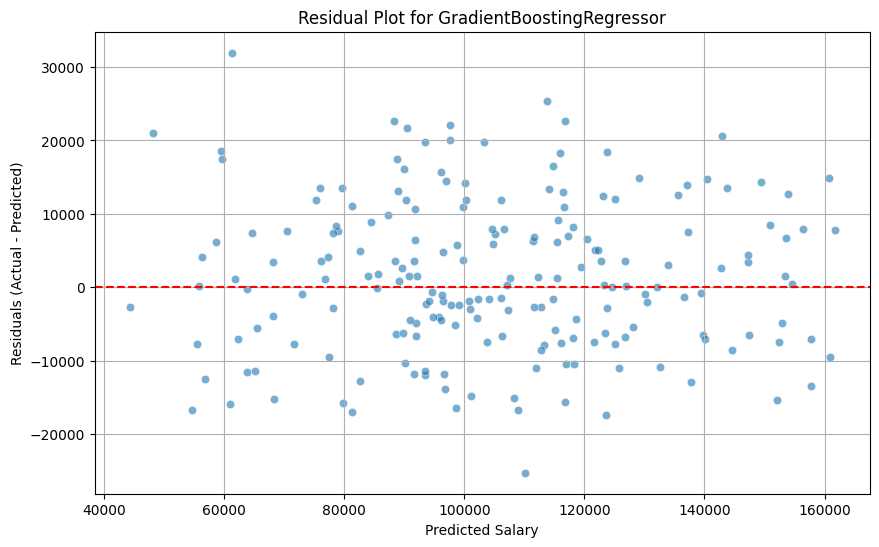

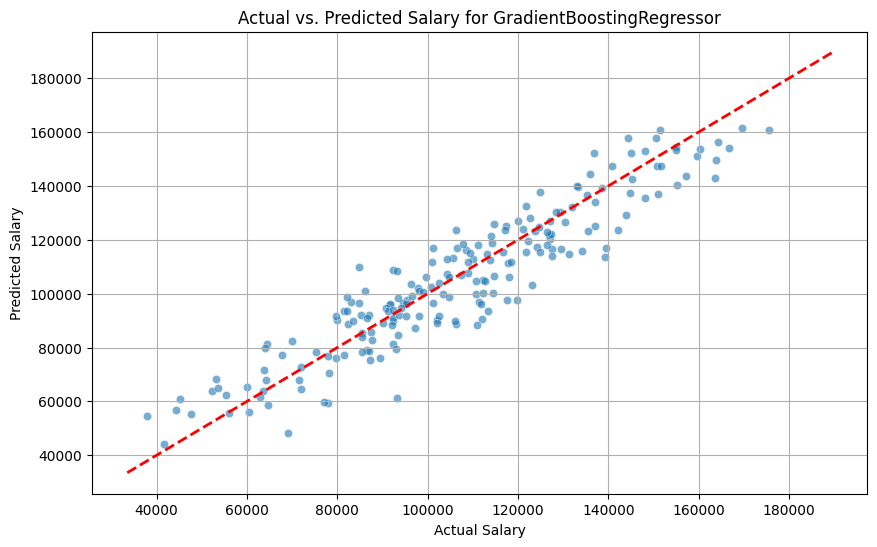

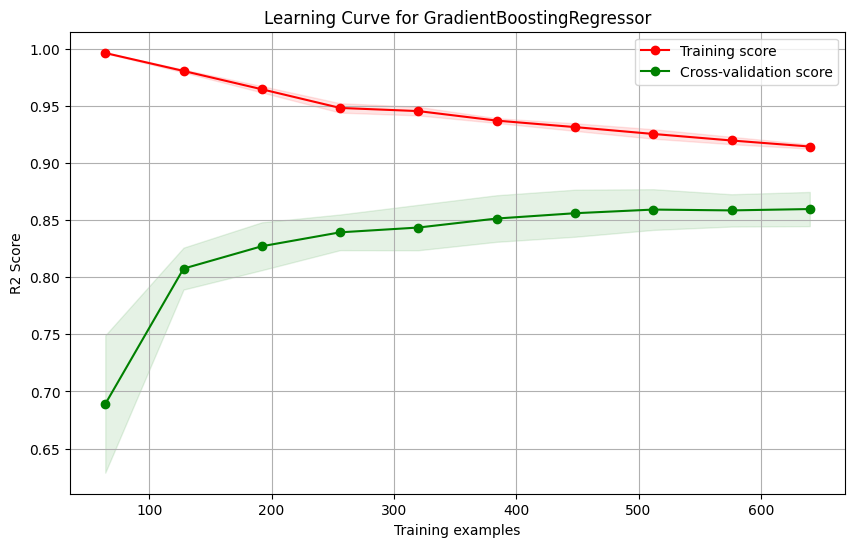

In [49]:
print("\n--- Visualizing Performance of Best Model ---")

# Residual Plot
y_test_pred_best = best_model.predict(X_test_scaled_df)
residuals = y_test - y_test_pred_best

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_pred_best, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Predicted Salary')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

# Predicted vs Actual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred_best, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Diagonal line
plt.title(f'Actual vs. Predicted Salary for {best_model_name}')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.grid(True)
plt.show()

# Learning Curves (for the best model)
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled_df, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='r2'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title(f'Learning Curve for {best_model_name}')
plt.xlabel("Training examples")
plt.ylabel("R2 Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()


Feature Importance (for tree-based models)


--- Feature Importances (from Best Model) ---
|            | 0           |
|:-----------|:------------|
| Education  | 0.688356    |
| Job_Title  | 0.144743    |
| Experience | 0.124449    |
| Location   | 0.0262601   |
| Age        | 0.0154527   |
| Gender     | 0.000738474 |


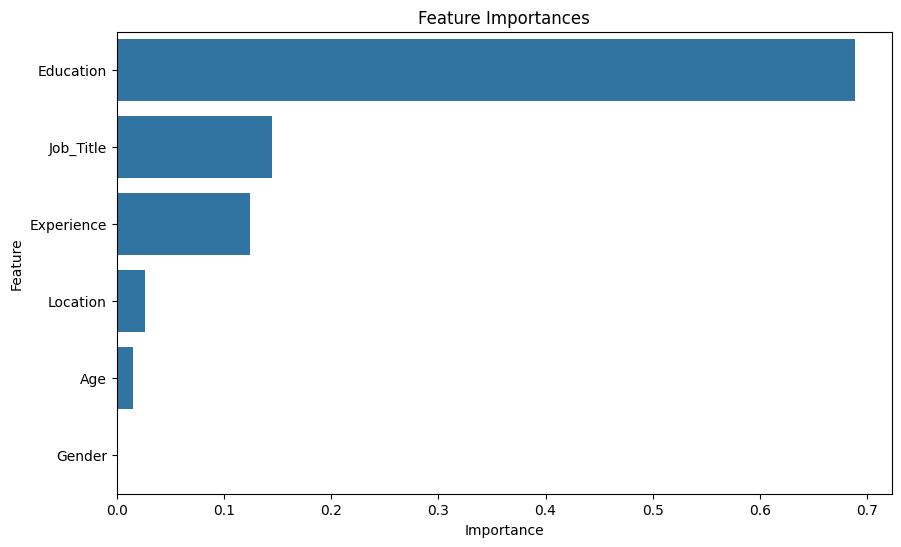

In [50]:
if hasattr(best_model, 'feature_importances_'):
    feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
    print("\n--- Feature Importances (from Best Model) ---")
    print(feature_importances.sort_values(ascending=False).to_markdown(numalign="left", stralign="left"))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances.sort_values(ascending=False), y=feature_importances.sort_values(ascending=False).index)
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()


Streamlit GUI

In [63]:
!streamlit run app.py

^C
